In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,random_split
import numpy as np

In [ ]:
# Define VAE loss function
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE loss for denoising task)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div

In [ ]:
def mse(original, reconstructed):
    return F.mse_loss(reconstructed, original).item()

def mae(original, reconstructed):
    return F.l1_loss(reconstructed, original).item()

In [ ]:
# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Function to add random noise
def add_noise(img, noise_factor=0.3):
    noisy_img = img + noise_factor * torch.randn_like(img)
    return torch.clamp(noisy_img, 0., 1.)

# Function to add Gaussian noise to images
def add_gaussian_noise(img, mean=0.0, std=0.3):
    noise = torch.normal(mean, std, size=img.shape).to(img.device)
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

def add_speckle_noise(img, mean=0.0, std=0.5):
    noise = torch.normal(mean, std, size=img.shape).to(img.device)
    noisy_img = img + img * noise  # Image-dependent noise
    return torch.clamp(noisy_img, 0., 1.)  # Keep values in [0,1]

def add_salt_pepper_noise(img, salt_prob=0.1, pepper_prob=0.02):
    noisy_img = img.clone()

    # Generate random masks
    salt_mask = torch.rand_like(img) < salt_prob
    pepper_mask = torch.rand_like(img) < pepper_prob

    # Apply salt (set to 1) and pepper (set to 0)
    noisy_img[salt_mask] = 1.0
    noisy_img[pepper_mask] = 0.0

    return noisy_img


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(VariationalAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 128, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

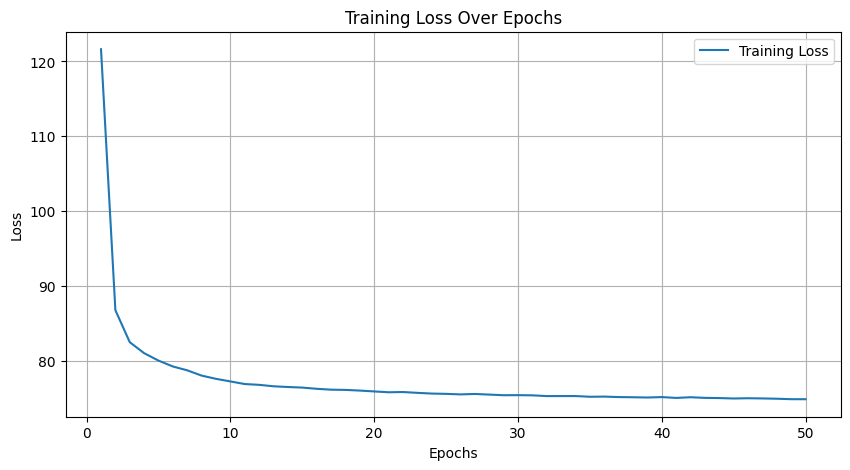

Training complete.


In [ ]:
# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_simple = VariationalAutoencoder(latent_dim=32).to(device)
optimizer = optim.Adam(vae_simple.parameters(), lr=1e-3)

# Training loop
epochs = 50
losses = []

for epoch in range(epochs):
    vae_simple.train()
    train_loss = 0

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        noisy_images = add_gaussian_noise(images)  # Add Gaussian noise

        optimizer.zero_grad()
        recon_images, mu, logvar = vae_simple(noisy_images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    #print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

print("Training complete.")

MSE: 0.013525
MAE: 0.085635


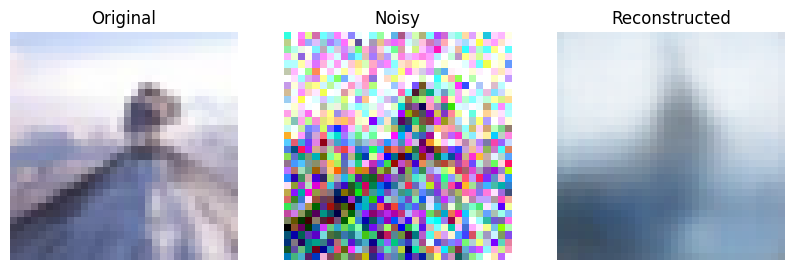

In [ ]:
# Testing: Show original, noisy, and reconstructed images
def show_images(original, noisy, reconstructed):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    axes[0].imshow(original.permute(1, 2, 0).cpu())  # Ensure CPU for visualization
    axes[0].set_title("Original")
    axes[1].imshow(noisy.permute(1, 2, 0).cpu())
    axes[1].set_title("Noisy")
    axes[2].imshow(reconstructed.permute(1, 2, 0).cpu())
    axes[2].set_title("Reconstructed")
    for ax in axes:
        ax.axis("off")
    plt.show()

vae_simple.eval()

def mse(original, reconstructed):
    return F.mse_loss(reconstructed, original).item()

def mae(original, reconstructed):
    return F.l1_loss(reconstructed, original).item()

with torch.no_grad():
    sample_image, _ = test_dataset[0]
    sample_image = sample_image.to(device)  # Move to the same device
    noisy_sample = add_gaussian_noise(sample_image).to(device).unsqueeze(0)

    reconstructed_sample, _, _ = vae_simple(noisy_sample)

    # Ensure all inputs are on the same device before loss calculation
    mse_value = mse(sample_image, reconstructed_sample.squeeze().to(device))
    mae_value = mae(sample_image, reconstructed_sample.squeeze().to(device))

    print(f"MSE: {mse_value:.6f}")
    print(f"MAE: {mae_value:.6f}")

    # Show images
    show_images(sample_image.cpu(), noisy_sample.squeeze().cpu(), reconstructed_sample.squeeze().cpu())

model_save_path = "vae_simple_model.pth"
torch.save(vae_simple.state_dict(), model_save_path)


In [ ]:
class MultiScaleVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(MultiScaleVAE, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32 + 32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder1(x)
        h2 = self.encoder2(h1)
        h3 = self.encoder3(h2)

        h3_flat = h3.view(h3.size(0), -1)
        mu = self.fc_mu(h3_flat)
        logvar = self.fc_logvar(h3_flat)
        return mu, logvar, (h1, h2, h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skips):
        h1, h2, _ = skips
        h = self.fc_decode(z)
        h = h.view(h.size(0), 128, 4, 4)
        h = self.decoder1(h)
        h = self.decoder2(torch.cat([h, h2], dim=1))  # Multi-scale skip connection
        h = self.decoder3(torch.cat([h, h1], dim=1))  # Multi-scale skip connection
        return h

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, skips), mu, logvar


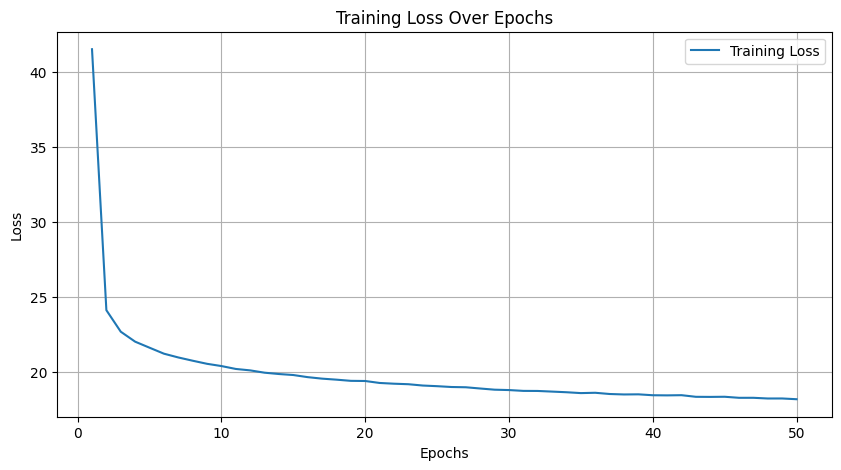

Training complete.


In [ ]:
# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_multiscale = MultiScaleVAE(latent_dim=32).to(device)
optimizer = optim.Adam(vae_multiscale.parameters(), lr=1e-3)

# Training loop
epochs = 50
losses = []

for epoch in range(epochs):
    vae_multiscale.train()
    train_loss = 0

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        noisy_images = add_gaussian_noise(images)  # Add Gaussian noise

        optimizer.zero_grad()
        recon_images, mu, logvar = vae_multiscale(noisy_images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    #print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

print("Training complete.")

MSE: 0.004174
MAE: 0.047644


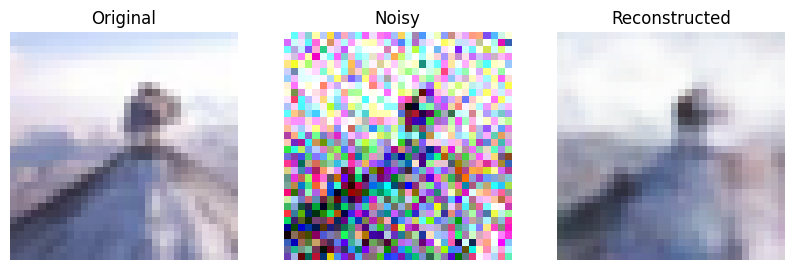

In [ ]:
# Testing: Show original, noisy, and reconstructed images
def show_images(original, noisy, reconstructed):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    axes[0].imshow(original.permute(1, 2, 0).cpu())  # Ensure CPU for visualization
    axes[0].set_title("Original")
    axes[1].imshow(noisy.permute(1, 2, 0).cpu())
    axes[1].set_title("Noisy")
    axes[2].imshow(reconstructed.permute(1, 2, 0).cpu())
    axes[2].set_title("Reconstructed")
    for ax in axes:
        ax.axis("off")
    plt.show()

vae_multiscale.eval()

def mse(original, reconstructed):
    return F.mse_loss(reconstructed, original).item()

def mae(original, reconstructed):
    return F.l1_loss(reconstructed, original).item()

with torch.no_grad():
    sample_image, _ = test_dataset[0]
    sample_image = sample_image.to(device)  # Move to the same device
    noisy_sample = add_gaussian_noise(sample_image).to(device).unsqueeze(0)

    reconstructed_sample, _, _ = vae_multiscale(noisy_sample)

    # Ensure all inputs are on the same device before loss calculation
    mse_value = mse(sample_image, reconstructed_sample.squeeze().to(device))
    mae_value = mae(sample_image, reconstructed_sample.squeeze().to(device))

    print(f"MSE: {mse_value:.6f}")
    print(f"MAE: {mae_value:.6f}")

    # Show images
    show_images(sample_image.cpu(), noisy_sample.squeeze().cpu(), reconstructed_sample.squeeze().cpu())

model_save_path = "vae_multiscale_model.pth"
torch.save(vae_multiscale.state_dict(), model_save_path)


In [ ]:
class AdaptiveFilterVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(AdaptiveFilterVAE, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32 + 32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        # Adaptive filtering weight module
        self.attention = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder1(x)
        h2 = self.encoder2(h1)
        h3 = self.encoder3(h2)
        h3_flat = h3.view(h3.size(0), -1)
        mu = self.fc_mu(h3_flat)
        logvar = self.fc_logvar(h3_flat)
        return mu, logvar, (h1, h2, h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skips):
        h1, h2, _ = skips
        h = self.fc_decode(z)
        h = h.view(h.size(0), 128, 4, 4)
        h = self.decoder1(h)
        h = self.decoder2(torch.cat([h, h2], dim=1))
        h = self.decoder3(torch.cat([h, h1], dim=1))
        return h

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, skips)

        # Adaptive weighting between original and reconstructed image
        alpha = self.attention(x)  # Learnable attention mask (per pixel)
        filtered_x = alpha * recon_x + (1 - alpha) * x  # Blend original and reconstructed

        return filtered_x, mu, logvar, recon_x


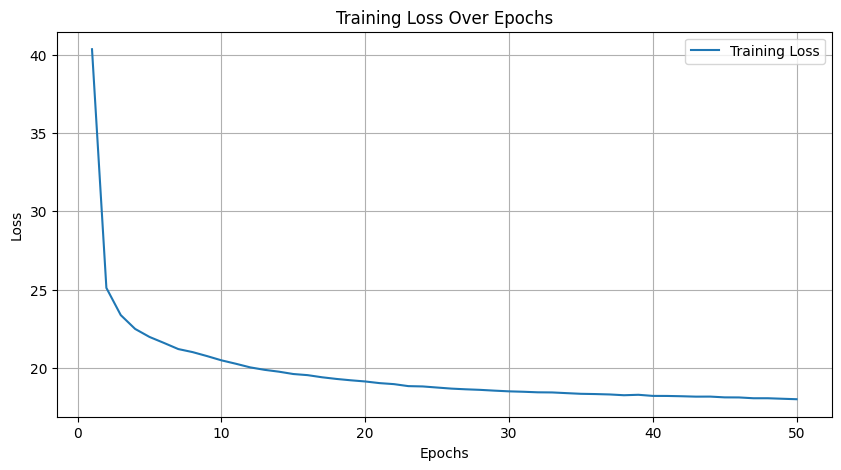

Training complete.


In [ ]:
# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_adaptive = AdaptiveFilterVAE(latent_dim=32).to(device)
optimizer = optim.Adam(vae_adaptive.parameters(), lr=1e-3)

# Training loop
epochs = 50
losses = []

for epoch in range(epochs):
    vae_adaptive.train()
    train_loss = 0

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        noisy_images = add_gaussian_noise(images)  # Add Gaussian noise

        optimizer.zero_grad()
        filtered_images, mu, logvar, recon_images = vae_adaptive(noisy_images)
        loss = loss_function(filtered_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    losses.append(avg_loss)

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

print("Training complete.")

MSE: 0.004060
MAE: 0.048153


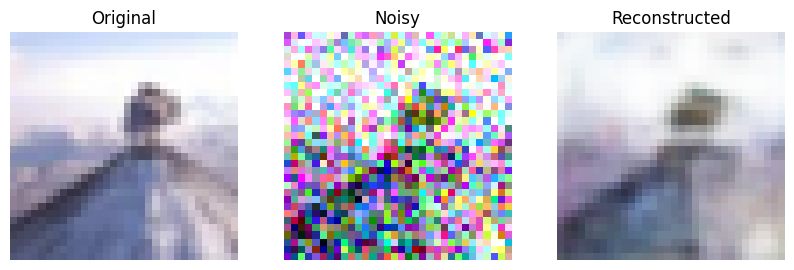

In [ ]:
def show_images(original, noisy, reconstructed):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    axes[0].imshow(original.permute(1, 2, 0).cpu())
    axes[0].set_title("Original")
    axes[1].imshow(noisy.permute(1, 2, 0).cpu())
    axes[1].set_title("Noisy")
    axes[2].imshow(reconstructed.permute(1, 2, 0).cpu())
    axes[2].set_title("Reconstructed")
    for ax in axes:
        ax.axis("off")
    plt.show()


vae_adaptive.eval()

with torch.no_grad():
    sample_image, _ = test_dataset[0]
    sample_image = sample_image.to(device)
    noisy_sample = add_gaussian_noise(sample_image).unsqueeze(0)
    filtered_sample, _, _, reconstructed_sample = vae_adaptive(noisy_sample)

    # Calculate measures
    mse_value = mse(sample_image, reconstructed_sample.squeeze())
    mae_value = mae(sample_image, reconstructed_sample.squeeze())

    print(f"MSE: {mse_value:.6f}")
    print(f"MAE: {mae_value:.6f}")

    # Show images
    show_images(sample_image.cpu(), noisy_sample.squeeze().cpu(), reconstructed_sample.squeeze().cpu())

model_save_path = "vae_adaptive_model.pth"
torch.save(vae_adaptive.state_dict(), model_save_path)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalMultiScaleVAE(nn.Module):
    def __init__(self, latent_dim=32, num_classes=100):
        super(ConditionalMultiScaleVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Label embedding
        self.label_emb = nn.Linear(num_classes, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32 + 32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder1(x)
        h2 = self.encoder2(h1)
        h3 = self.encoder3(h2)

        h3_flat = h3.view(h3.size(0), -1)
        mu = self.fc_mu(h3_flat)
        logvar = self.fc_logvar(h3_flat)
        return mu, logvar, (h1, h2, h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skips, labels):
        h1, h2, _ = skips
        label_embedding = self.label_emb(labels)
        z = z + label_embedding  # Conditioning on labels

        h = self.fc_decode(z)
        h = h.view(h.size(0), 128, 4, 4)
        h = self.decoder1(h)
        h = self.decoder2(torch.cat([h, h2], dim=1))  # Multi-scale skip connection
        h = self.decoder3(torch.cat([h, h1], dim=1))  # Multi-scale skip connection
        return h

    def forward(self, x, labels):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, skips, labels), mu, logvar


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = F.one_hot(torch.tensor(labels), num_classes=100).float()
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)


Files already downloaded and verified
Files already downloaded and verified


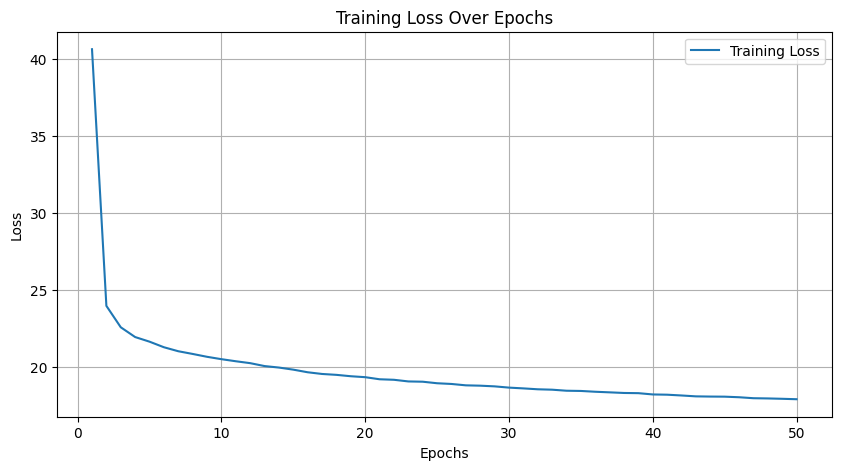

Training complete.


In [ ]:
# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_multiscale = ConditionalMultiScaleVAE(latent_dim=32, num_classes=100).to(device)
optimizer = optim.Adam(vae_multiscale.parameters(), lr=1e-3)

# Training loop
epochs = 50
losses = []

for epoch in range(epochs):
    vae_multiscale.train()
    train_loss = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        noisy_images = add_gaussian_noise(images)  # Add Gaussian noise

        optimizer.zero_grad()
        recon_images, mu, logvar = vae_multiscale(noisy_images, labels)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    #print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

print("Training complete.")


MSE: 0.004690
MAE: 0.050310


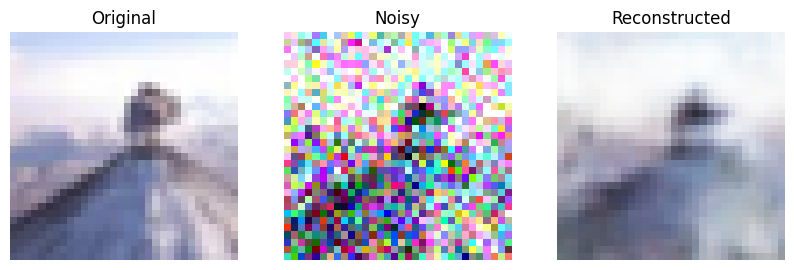

In [ ]:
def show_images(original, noisy, reconstructed):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    axes[0].imshow(original.permute(1, 2, 0).cpu())
    axes[0].set_title("Original")
    axes[1].imshow(noisy.permute(1, 2, 0).cpu())
    axes[1].set_title("Noisy")
    axes[2].imshow(reconstructed.permute(1, 2, 0).cpu())
    axes[2].set_title("Reconstructed")
    for ax in axes:
        ax.axis("off")
    plt.show()

vae_multiscale.eval()

with torch.no_grad():
    sample_image, sample_label = test_dataset[0]
    sample_image = sample_image.to(device)
    sample_label = F.one_hot(torch.tensor(sample_label), num_classes=100).float().to(device)
    noisy_sample = add_gaussian_noise(sample_image).unsqueeze(0)
    reconstructed_sample, _, _ = vae_multiscale(noisy_sample, sample_label.unsqueeze(0))

    # Calculate measures
    mse_value = F.mse_loss(sample_image, reconstructed_sample.squeeze()).item()
    mae_value = F.l1_loss(sample_image, reconstructed_sample.squeeze()).item()

    print(f"MSE: {mse_value:.6f}")
    print(f"MAE: {mae_value:.6f}")

    # Show images
    show_images(sample_image.cpu(), noisy_sample.squeeze().cpu(), reconstructed_sample.squeeze().cpu())